<a href="https://colab.research.google.com/github/rz-pb/ML-Project-SimpleMKKM/blob/main/Simple_Multiple_Kernel_K_means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Course - Final Project
Departmant of Computer Science, Shahid Beheshti University

**Supervisor**: Dr.Katanforoush.

**Student** : Reza Pourbahreini

**ID**: 400422049

# Introduction

## Clustering

<p align= "justify"><b>Clustering</b> is the task of grouping a set of objects in such a way that objects in the same group (called a <i>cluster</i>) are more similar (in some sense) to each other than to those in other groups (clusters).</p>

## K-means
<p align= "justify"><b>K-means</b> is a popular <u>unsupervised machine learning algorithm</u> that partitions a dataset into $K$ clusters based on their <b>similarity</b>. The algorithm starts by randomly selecting $K$ initial centroids, and then assigns each data point to the closest centroid. Next, the centroids are recomputed as the mean of the assigned data points, and the process of assigning and updating centroids is repeated until convergence.</p>

<br>

<p align= "justify">Given a dataset $𝐗$ of $N$ data points, the objective of K-means is to partition the data into $K$ clusters by minimizing the within-cluster sum of squared distances (WCSS):</p>

$$J(C) = \sum_{k=1}^{K} \sum_{i=1}^{N} ||x_i - \mu_k||^2 $$
$$\text{, where $C$ is the partition of the data into $K$ clusters, $x_i$ is the i-th data point, and $μ_k$ is the mean of the k-th cluster.}$$


### Some toy examples to show how K-means works


As one might notice when the data is somewhat linearly separable, naive k-means gets the job done properly:

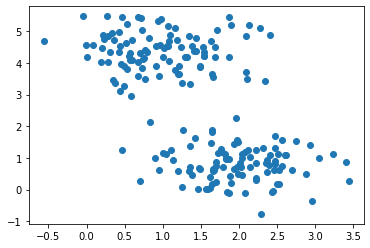

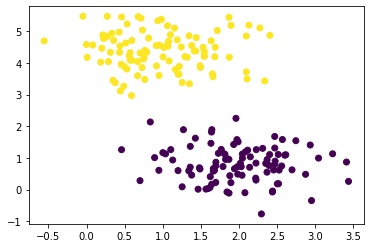

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate linearly non-separable dataset
X, y = make_blobs(n_samples = 200, cluster_std=0.6 ,centers=2 , n_features = 2 , random_state =0)

# Plot the generated dataset
plt.scatter(X[:,0], X[:,1])
plt.show()

# Perform k-means clustering on the dataset
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)

# Plot the clustered dataset
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.show()


But with more interwined datasets, things gets messy and there are different methods to tackle this problem based on the nature of data:

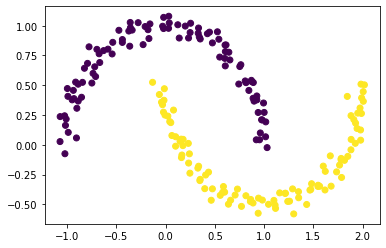

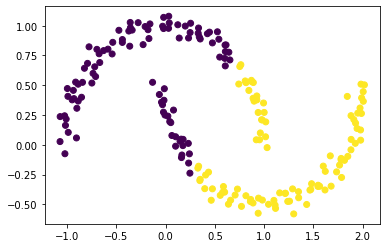

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans

# Generate linearly non-separable dataset
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# Plot the generated dataset
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Perform k-means clustering on the dataset
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)

# Plot the clustered dataset
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.show()


### Disadvantages of K-Means
There are a variety of conditions where K-Means may result in incorrect clustering.

K-Means may not perform well when:

- Clusters are non-spherical
- Clusters have different sizes
- Data has outliers
- Clusters are non-linearly separable
- Clusters have overlap
- Cluster centroids have poor initialization

## Kernel K-means
<p align="justify"> Kernel k-means clustering is a powerful tool for unsupervised learning of non-linearly separable data. Since the earliest attempts, researchers have noted that such algorithms often become trapped by local minima arising from non-convexity of the underlying objective function.</p>

<p align="justify"> Kernel methods can be applied when the objective function can be written as a function of dot products. This allows us to map our current feature vectors into higher dimensional spaces in a more computationally efficient manner using the kernel trick.</p>

<p align="justify"> As mentioned, K-Means performs best when clusters are spherical, dense, and linearly separable. For non-linearly separable clusters, we often would like to project our data into a higher dimensional space to make the resulting clusters linearly separable. Projecting to a higher dimension directly and calculating the objective for K-Means can be computationally expensive, as this requires calculating $𝐗^T𝐗$.</p>

<p align="justify"> Kernel trick allows us to project our data into a higher dimensional space to achieve linear separability and solve the K-Means problem in a more efficient way:</p>

In [ ]:
"""Kernel K-means"""

# Author: Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

import numpy as np

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state


class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means
    
    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="linear", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose
        
    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change 
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the 
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)




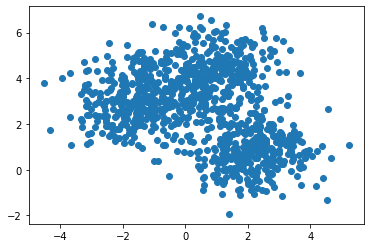

Converged at iteration 14


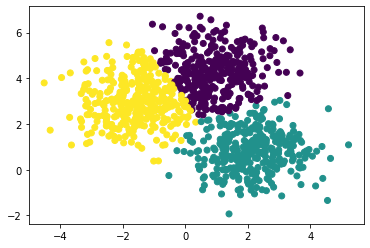

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=3, random_state=0)

km = KernelKMeans(n_clusters=3, max_iter=100, random_state=0, verbose=1)
# print(km.fit_predict(X)[:10])
# print(km.predict(X[:10]))

# Plot the generated dataset
plt.scatter(X[:,0], X[:,1])
plt.show()

# Plot the clustered dataset
plt.scatter(X[:,0], X[:,1], c=km.fit_predict(X,y=y))
plt.show()

### Applying linear kernel: [Not a good choice!]

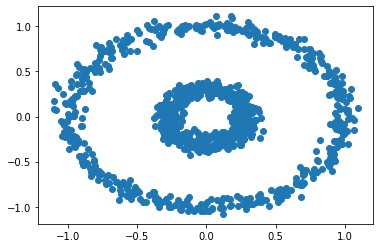

Converged at iteration 7


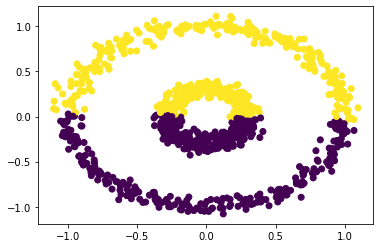

'linear'

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples= 1000, factor=.3,noise=.05)

km = KernelKMeans(n_clusters=2, kernel="linear", gamma=2, degree=0, coef0=1, max_iter=100, random_state=0, verbose=1)
# print(km.fit_predict(X)[:10])
# print(km.predict(X[:10]))

# Plot the generated dataset
plt.scatter(X[:,0], X[:,1])
plt.show()

# Plot the clustered dataset
plt.scatter(X[:,0], X[:,1], c=km.fit_predict(X,y=y))
plt.show()

km.kernel

### Applying Radial-basis-function kernel: [Good choice!]

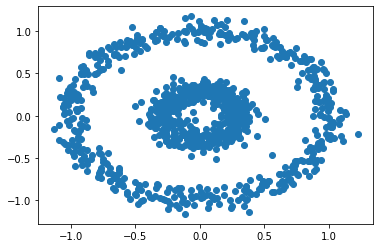

Converged at iteration 4


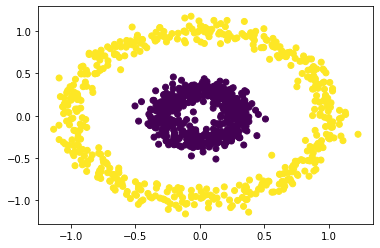

'rbf'

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples= 1000, factor=.3,noise=.07)

km = KernelKMeans(n_clusters=2, kernel="rbf", gamma=2, degree=1, coef0=1, max_iter=100, random_state=0, verbose=1)
# print(km.fit_predict(X)[:10])
# print(km.predict(X[:10]))

# Plot the generated dataset
plt.scatter(X[:,0], X[:,1])
plt.show()

# Plot the clustered dataset
plt.scatter(X[:,0], X[:,1], c=km.fit_predict(X,y=y))
plt.show()

km.kernel

## Multiple Kernel K-means (MK-Kmeans)

<p align= "justify"><b>MK-Kmeans</b> extends the K-means algorithm to multiple kernels by defining a kernel matrix for each data point. Given a set of $M$ kernels $K_m$, the objective of MK-Kmeans is to minimize the sum of squared distances between the data points and their assigned centroids with respect to each kernel:</p>

$$J(C) = \sum_{m=1}^{M} \sum_{k=1}^{K} \sum_{i=1}^{N} w_{m,k} K_m(x_i, \mu_k)$$

$$\text{, where $w_{m,k}$ is the weight assigned to the k-th cluster with respect to the m-th kernel.}$$


<p align= "justify">In <b>multiple kernel clustering (MKC)</b>, we aim to combine a set of pre-specified kernel matrices to improve clustering performance. These kernel matrices could encode heterogeneous sources or views of the data. One popular method, multiple kernel k-means(MKKM) has been studied intensively and used in various applications.</p>

<p align= "justify">The objective functions of different methods differ,but they all share one commonality: they learn the <b>kernel coefficient</b> and the <b>clustering partition matrix</b> <i>jointly</i>. By this way, the leaned kernel coefficient can best serve the clustering, leading to superior clustering performance.</p>

## Simple Multiple Kernel K-means (Simple-MKKM)
<p align= "justify"><b>Simple-MKKM</b> simplifies <b>MK-Kmeans</b> by using a linear combination of kernels rather than considering each kernel separately. Given a set of $M$ kernels $K_m$ and their corresponding weights $λ_m$, the objective of Simple-MKKM is to minimize the following:</p>

$$J(C) = \sum_{k=1}^{K} \sum_{i=1}^{N} ||x_i - \mu_k||^2_{\Phi}$$

$$\text{,where $\Phi = \sum_{m=1}^{M} \lambda_m K_m$.}$$

<p align= "justify">Unlike previous approaches, Simple-MKKM optimizes the unsupervised kernel alignment criterion directly. Specifically, it minimizes kernel alignment with respect to the kernel coefficient and maximizes it with respect to the clustering matrix.</p>

<p align= "justify">However, it will be showed that this min-max problem actually leads to a more efficient and effective optimization algorithm. Specifically, with reformulation of the min-max problem as a minimization problem, whose objective relies on the known optimal solution to kernel k-means. Then the differentiability of the optimal value function will be proved and its reduced gradient will be calculated. This leads to a solution using a reduced gradient descent algorithm, without alternating optimization.</p>

so the following optimization problem:

$$ \min_{\gamma\in\Delta} \max_{\textbf{H}}\rm{Tr}\big( \textbf{K}_{\gamma}\textbf{H}\textbf{H}^{\intercal}\big)$$

$$ \text{s.t    } \textbf{H} \in ℝ^{n \times k} , \textbf{H}^{\intercal}\textbf{H}= 𝐈_k $$ 

$$ \text{,where   } \Delta =\{ \gamma \in ℝ^m | \sum_{p=1}^m \gamma_p=1 , \gamma_p \ge 0, \forall p\} \text{   and   } \textbf{K}_{\gamma} = \sum_{p=1}^m \gamma_p^2 \textbf{K}_p $$

can be rewritten as:

$$ \min_{\gamma\in\Delta} 𝓙(\gamma),$$
$$ \text{with   } 𝓙(\gamma)=\{ \max_{\textbf{H}}\rm{Tr}\big( \textbf{K}_{\gamma}\textbf{H}\textbf{H}^{\intercal}) \text{    s.t  } \textbf{H}^{\intercal}\textbf{H}= 𝐈_k \}$$

### Dataset

17 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 17 different categories. 
The images were acquired by searching the web and taking pictures. There are
80 images for each category. 

The database was used in:

Nilsback, M-E. and Zisserman, A.  A Visual Vocabulary for Flower Classification.
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (2006) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.{pdf,ps.gz}.

The datasplits used in this paper are specified in datasplits.mat

There are 3 separate splits. The results in the paper are averaged over the 3 splits.
Each split has a training file (trn1,trn2,trn3), a validation file (val1, val2, val3)
and a testfile (tst1, tst2 or tst3). 

Segmentation Ground Truth
------------------------------------------------
The ground truth is given for a subset of the images from 13 different
categories. 

More details can be found in:

Nilsback, M-E. and Zisserman, A. Delving into the whorl of flower segmentation.
Proceedings of the British Machine Vision Conference (2007)
http:www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.(pdf,ps.gz).

The ground truth file also contains the file imlist.mat, which indicated
which images in the original database that have been anotated.

Distance matrices
-----------------------------------------------

We provide two set of distance matrices:

1. distancematrices17gcfeat06.mat 
- Distance matrices using the same features and segmentation as detailed in:
    Nilsback, M-E. and Zisserman, A.  A Visual Vocabulary for Flower Classification.
    Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition(2006)
    http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.{pdf,ps.gz}.

2. distancematrices17itfeat08.mat
- Distance matrices using the same features as described in: 
    Nilsback, M-E. and Zisserman, A. Automated flower classification over a large number of classes.
    Proceedings of the Indian Conference on Computer Vision, Graphics and Image Processing (2008)
    http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback08.{pdf,ps.gz}.
  and the iterative segmenation scheme detailed in 
    Nilsback, M-E. and Zisserman, A. Delving into the whorl of flower segmentation.
    Proceedings of the British Machine Vision Conference (2007)
    http:www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.(pdf,ps.gz).


![flowers](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/categories.jpg)

### Additional Codes

There are two directories in the repository in which there are original codes of the paper in MATLAB scripting language and also another third-party python code.

 The original codes have been implemented on the dataset using MATLAB or Octave programs.